### Currently, this notebook is used for:
    - loading the sfMixLGN experiment data in python format
    - plotting responses

### Set up

In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import helper_fcns
import autoreload
import scipy.optimize as opt

import sys # so that we can import model_responses (in different folder)
import model_responses

% matplotlib inline 

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/Analysis/Functions/paul_plt_style.mplstyle');

# at CNS
# dataPath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/recordings/';
# savePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/';
# personal mac
dataPath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/structures/';
save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/figures/';

conDig = 3; # round contrast to the 3rd digit
fullWaveform = 0;

which_cell = 31; # which cell - index will be which_cell - 1

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();

if fullWaveform:
    waveStr = '_fullWave'
else:
    waveStr = '';
    
cellStruct = np.load(dataPath + dataList['unitName'][which_cell-1] + '_sfm' + waveStr + '.npy', encoding='latin1').item();

In [2]:
data = cellStruct['sfm']['exp']['trial'];

A quick look at spikes versus f1 power, and a check of my fourier analysis of the data

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 10));
ax[0].plot(np.abs(data['f1']), np.abs(data['spikeCount']), 'o');
ax[0].set_xlabel('f1');
ax[0].set_ylabel('spike count');

zzz = [x[0] if np.all(~np.isnan(x)) else x for x in data['power_f1']] 
# get the first value of each power_f1 array to compare to the values expo gave
ax[1].plot(np.abs(data['f1']), np.abs(zzz), 'o');
ax[1].set_xlabel('f1 - expo');
ax[1].set_ylabel('f1 - me');


### Organize data
#### determine contrasts, center spatial frequency, dispersions

In [ ]:
data = cellStruct['sfm']['exp']['trial'];

resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = helper_fcns.tabulate_responses(cellStruct);

all_disps = stimVals[0];
all_cons = stimVals[1];
all_sfs = stimVals[2];

nCons = len(all_cons);
nSfs = len(all_sfs);
nDisps = len(all_disps);

#### Unpack responses

In [ ]:
autoreload.reload(helper_fcns);

In [ ]:
# respMean = resp[0];
# respStd = resp[1];
predMean = resp[2];
predStd = resp[3];
respMean = resp[4];
respStd = resp[5];
predF1mean = resp[6];
predF1std = resp[7];
rM_summary = np.reshape([np.sum(x) for x in respMean.flatten()], respMean.shape)
rS_summary = np.reshape([np.sqrt(np.sum(np.square(x))) for x in respStd.flatten()], respStd.shape)

In [ ]:
z = respMean[1, :, :].flatten()

In [ ]:
zz = [np.max(x) for x in z]

#### Load descriptive model fits

In [ ]:
a1 = np.array([5, 4, 6, 1, 4]);
a2 = np.array([1, 1, 1, 1, 1]);

b1 = np.array([4, 3, 6, 0.5, 6]);
b2 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]);

In [ ]:
m = [a1, b1];
s = [a2, b2];

In [ ]:
c = [np.repeat(1, 5), np.repeat(2, 5)]

In [ ]:
# plt.errorbar([1, 2], [a1[4], b1[4]], [a2[4], b2[4]]);
plt.errorbar([1, 2], [a1, b1], [a2, b2]);

In [ ]:
zz = np.array([]);
zz = np.append(zz, ['mix', 'isol'])
zz = np.append(zz, ['mix', 'isol'])
zz = np.append(zz, ['mix', 'isol'])

In [ ]:
descrFits = np.load(dataPath + 'descrFits.npy', encoding = 'latin1').item();
descrFits = descrFits[which_cell-1]['params']; # just get this cell

### Plots

#### Plots by dispersion

In [ ]:
fDisp = []; dispAx = [];

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);    

for d in range(nDisps):
    
    v_cons = val_con_by_disp[d];
    n_v_cons = len(v_cons);
    
    fCurr, dispCurr = plt.subplots(n_v_cons, 1, figsize=(40, n_v_cons*10));
    fDisp.append(fCurr)
    dispAx.append(dispCurr);
    
    maxResp = np.max(np.max(respMean[d, ~np.isnan(respMean[d, :, :])]));
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = len(v_cons) - c - 1;
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                      respStd[d, v_sfs, v_cons[c]], fmt='o');
        # plot linear prediction
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x');
        
        # plot descriptive model fit
#         curr_mod_params = descrFits[d, v_cons[c], :];
        #dispAx[d][c_plt_ind].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))
        
        dispAx[d][c_plt_ind].set_xlim((min(all_sfs), max(all_sfs)));
        dispAx[d][c_plt_ind].set_ylim((0, 1.5*maxResp));
        
        dispAx[d][c_plt_ind].set_xscale('log');
#         dispAx[d][c].set_yscale('log');
        dispAx[d][c_plt_ind].set_xlabel('sf (c/deg)'); 
        dispAx[d][c_plt_ind].set_ylabel('resp (sps)');
        dispAx[d][c_plt_ind].set_title('D%d: contrast: %.3f' % (d+1, all_cons[v_cons[c]]));


saveName = "/cell_%d.pdf" % (which_cell)
full_save = os.path.dirname(str(save_loc + 'byDisp/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fDisp:
    pdfSv.savefig(f)
pdfSv.close()


#### Plot just sfMix contrasts

In [ ]:
# i.e. highest (up to) 4 contrasts for each dispersion

plot_descr = 0;

mixCons = 4;
maxResp = np.max(np.max(np.max(respMean[~np.isnan(respMean)])));

f, sfMixAx = plt.subplots(mixCons, nDisps, figsize=(40, 30));

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

for d in range(nDisps):
    v_cons = np.array(val_con_by_disp[d]);
    n_v_cons = len(v_cons);
    v_cons = v_cons[np.arange(np.maximum(0, n_v_cons -mixCons), n_v_cons)]; # max(1, .) for when there are fewer contrasts than 4
    n_v_cons = len(v_cons);
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = n_v_cons - c - 1;
        sfMixAx[c_plt_ind, d].set_title('con:' + str(np.round(all_cons[v_cons[c]], 2)))
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                       respStd[d, v_sfs, v_cons[c]], fmt='o');

        # plot linear prediction
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x');
        
        # plot descriptive model fit
        if plot_descr:
            curr_mod_params = descrFits[d, v_cons[c], :];
        #sfMixAx[c_plt_ind, d].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))

        sfMixAx[c_plt_ind, d].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        sfMixAx[c_plt_ind, d].set_ylim((0, 1.5*maxResp));
        sfMixAx[c_plt_ind, d].set_xscale('log');
        sfMixAx[c_plt_ind, d].set_xlabel('sf (c/deg)');
        sfMixAx[c_plt_ind, d].set_ylabel('resp (sps)');
        
saveName = "/cell_%d.pdf" % (which_cell)
full_save = os.path.dirname(str(save_loc + 'sfMixOnly/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

#### Plot contrast response functions

In [ ]:
crfAx = []; fCRF = [];

for d in range(nDisps):
    
    # which sfs have at least one contrast presentation?
    v_sfs = np.where(np.sum(~np.isnan(respMean[d, :, :]), axis = 1) > 0);
    n_v_sfs = len(v_sfs[0])
    fCurr, crfCurr = plt.subplots(1, n_v_sfs, figsize=(n_v_sfs*15, 20), sharex = True, sharey = True);
    fCRF.append(fCurr)
    crfAx.append(crfCurr);
    
    for sf in range(n_v_sfs):
        sf_ind = v_sfs[0][sf];
        v_cons = ~np.isnan(respMean[d, sf_ind, :]);
        n_cons = sum(v_cons);
        
        # 0.1 minimum to keep plot axis range OK...should find alternative
        crfAx[d][sf].errorbar(all_cons[v_cons], np.maximum(np.reshape([respMean[d, sf_ind, v_cons]], (n_cons, )), 0.1),
                            np.reshape([respStd[d, sf_ind, v_cons]], (n_cons, )), fmt='o');
        crfAx[d][sf].set_xscale('log');
        crfAx[d][sf].set_yscale('log');
        crfAx[d][sf].set_xlabel('contrast');
        crfAx[d][sf].set_ylabel('resp (sps)');
        crfAx[d][sf].set_title('D%d: sf: %.3f' % (d+1, all_sfs[sf_ind]));

saveName = "/cell_%d.pdf" % (which_cell)
full_save = os.path.dirname(str(save_loc + 'CRF/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fCRF:
    pdfSv.savefig(f)
pdfSv.close()

### Fourier analysis

In [ ]:
autoreload.reload(helper_fcns);

Section for testing out Fourier analysis in python - create a PSTH from the spike times and take the Fourier transform to determine the response amplitude at a given frequency. We will looking specifically for responses at the stimulus temporal frequencies. 

First, find out which trials are valid (i.e. not blanks)

In [ ]:
val_trials = np.where(~np.isnan(data['tf'][0]))[0];

Sort the data in terms of which trials have the largest f1 component

In [ ]:
b = np.argsort(np.abs(data['f1'][val_trials]))

Now which of those indices correspond to dispersed gratings (just so it's easier to check)

In [ ]:
np.where(data['num_comps'][val_trials][b] == 5)[0]

Organize the temporal frequencies for each (valid) trial

In [ ]:
sp = np.array(np.nan * np.zeros(900, ), dtype='O')

In [ ]:
sp[5]

In [ ]:
bbbb.dtype

In [ ]:
bbbb = np.vstack((data['tf'][0], data['tf'][1], data['tf'][2], data['tf'][3], data['tf'][4]));
all_all_tfs = np.transpose(bbbb)[val_trials];
all_tfs = all_all_tfs.astype(int)
atz = [[x[0]] if x[0] == x[1] else x for x in all_tfs];

Now do the analysis: create psth, fourier transform

In [ ]:
binWidth = 1e-3; # in s
whichInd = 890; # which index into "b"
stimDur = 1; # in s

In [ ]:
psth_blank, _ = helper_fcns.make_psth(binWidth, stimDur, allSpikes);
spect_blank, _ = helper_fcns.spike_fft(psth_blank);

In [ ]:
psth, _ = helper_fcns.make_psth(binWidth, stimDur, allSpikes[val_trials]);
psth_abbr = [x[50:] for x in psth];

In [ ]:
rel_power[b[820]]

In [ ]:
spect, rel_power = helper_fcns.spike_fft(psth, atz);
spect_abbr, rel_power_abbr = helper_fcns.spike_fft(psth_abbr, all_tfs);

In [ ]:
allSpikes = data['spikeTimes'];
valInd = b[whichInd];
trial = val_trials[valInd];

times = np.linspace(0, stimDur, 1+stimDur/binWidth);
c1 = []; c2 = []; c3 = []; c4 = []; c5 = [];

sfs_curr = [x[trial] for x in data['sf']];
cons_curr = [x[trial] for x in data['con']];

tfs_curr = all_tfs[valInd]; # index the below separately, since we've already "killed" invalid trials from this 
psth_curr = psth[valInd];
spect_curr = spect[valInd];
rel_power_curr = rel_power[valInd];

psth_abbr_curr = psth_abbr[valInd]; 
spect_abbr_curr = spect_abbr[valInd];
rp_abbr_curr = rel_power_abbr[valInd];

nyquist = int(len(spectrum)/2);
crop_fft = int(np.minimum(nyquist, 3*np.max(tfsCurr)));

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(20, 4))

plt.subplot(1, 3, 1);
plt.plot(times[0:-1], psth_blank);
# plt.plot(times[0:-1], psth_curr);
# plt.plot(times[0:-1], psth);
plt.xlabel('time (s)');
plt.ylabel('spikes (count)')

plt.subplot(1, 3, 2);
plt.stem(np.abs(spect_blank[0:crop_fft]), alpha=0.4);
# plt.stem(np.abs(spect_curr[0:crop_fft]), alpha=0.4);
# plt.stem(np.abs(spect_abbr_curr[0:crop_fft]), alpha=0.4, color='r');
c1 = plt.axvline(tfs_curr[0], ls='dashed', color='k');
if data['num_comps'][trial] > 1:
    c2 = plt.axvline(tfs_curr[1], ls='dashed', color='r')
    c3 = plt.axvline(tfs_curr[2], ls='dashed', color='g')
    c4 = plt.axvline(tfs_curr[3], ls='dashed', color='b')
    c5 = plt.axvline(tfs_curr[4], ls='dashed', color='c')
    
plt.xlabel('temporal frequency (hz)');
plt.ylabel('power')
if not c2:
    plt.legend([c1], ['stimulus TF'])
else:
    plt.legend((c1, c2, c3, c4, c5), ('tf1', 'tf2', 'tf3', 'tf4', 'tf5'));

plt.subplot(1, 3, 3);
if c2:
    full = plt.plot(np.arange(6), np.insert(rel_power_curr, 0, spect_curr[0]), 'o'); # to plot the DC
#     abbr = plt.plot(np.arange(6), np.insert(rp_abbr_curr, 0, spect_abbr_curr[0]), 'o'); # to plot the DC
    plt.xticks(np.arange(6), ('DC', 'tf1', 'tf2', 'tf3', 'tf4', 'tf5'))
    plt.xlim([-1, 7])
else:
    full = plt.plot(np.arange(2), [spect_curr[0], rel_power_curr[0]], 'o');
#     abbr = plt.plot(np.arange(2), [spect_abbr_curr[0], rp_abbr_curr[0]], 'o');
    plt.xticks(np.arange(2), ('DC', 'f1'))
    plt.xlim([-1, 3])
    
plt.xlabel('Stimulus component');
plt.ylabel('Power');
plt.ylim([-0.1*spect_curr[0], 1.1*spect_curr[0]]);
# plt.legend((full[0], abbr[0]), ('full', 'abbreviated'));

plt.suptitle('%s #%d, tr %d: (sf, con, tf, d) = (%.2f, %.2f, %d, %d)' % (dataList['unitType'][which_cell-1], which_cell, trial+1,
                                                                    sfs_curr[0], np.sum(cons_curr), tfs_curr[0], data['num_comps'][trial]));

## Thinking about phase

After a discussion with Tony, I now know that I have to consider not only the amplitude but the phase of fourier-transformed responses. We can determine the "proper" response phase of a neuron to a particular stimulus and project the component of the response only along this phase. TO see why this is important, imagine there is a baseline f1 response which is entirely noise and therefore occurs at arbitrary phases. The phase of this response will not be linked to the stimulus, and therefore is not stimulus-driven - thus we shouldn't count this is a stimulus-driven activity!

First, plot the (stimulus-blind) responses in 2D space - i.e. amplitude (r) and phase (phi) 

In [3]:
autoreload.reload(helper_fcns);

In [4]:
resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = helper_fcns.tabulate_responses(cellStruct);

print('dispersion values: ' + str(stimVals[0]))
print('con values: ' + str(np.round(stimVals[1], conDig)))
print('sf values (cpd): ' + str(np.round(stimVals[2], 2)))

print('\n')
for i in range(len(val_con_by_disp)):
    print(('Valid contrast indices for dispersion %d: ' + str(val_con_by_disp[i])) % i)
    
# for i in range()

dispersion values: [1 5]
con values: [0.05  0.073 0.106 0.154 0.224 0.325 0.469 0.473 0.682 0.688 0.992 1.   ]
sf values (cpd): [0.44 0.64 0.93 1.37 2.   2.93 4.29 6.28 9.19]


Valid contrast indices for dispersion 0: [0, 1, 2, 3, 4, 5, 7, 9, 11]
Valid contrast indices for dispersion 1: [6, 8, 10]


In [5]:
### pick which stimulus condition to analyze ###
disp = 0;
con = 11; # index
sf = 4; # index
# how many cycles to fold over? and what bin width in units of one period?
cycle_fold = 2; # fold over N cycles
n_bins = 8; # i.e. split each cycle (or period) into n_bins bins

# constants
binWidth = 1e-3;
stimDur = 1;

In [6]:
valDisp = validByStimVal[0];
valCon = validByStimVal[1];
valSf = validByStimVal[2];

allDisps = stimVals[0];
allCons = stimVals[1];
allSfs = stimVals[2];

val_trials = np.where(valDisp[disp] & valCon[con] & valSf[sf])

Now, actually compute the response phase relative to the stimulus phase!

In [7]:
ph_rel_stim, stim_phase, resp_phase, all_tf = helper_fcns.get_true_phase(data, val_trials);

In [8]:
psth_val, _ = helper_fcns.make_psth(binWidth, stimDur, data['spikeTimes'][val_trials])
_, rel_amp, full_fourier = helper_fcns.spike_fft(psth_val, all_tf)

Now the vector mean

In [9]:
r, th = helper_fcns.polar_vec_mean([rel_amp], [ph_rel_stim]);

Work with the spike times to create rasters (with stimulus cycle plotted) and then align each of the spikes relative to the stimulus cycle start

/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/functions/helper_fcns.py:130: RuntimeWarning: invalid value encountered in true_divide
  psth_norm = np.divide(psth_fold, np.max(psth_fold));


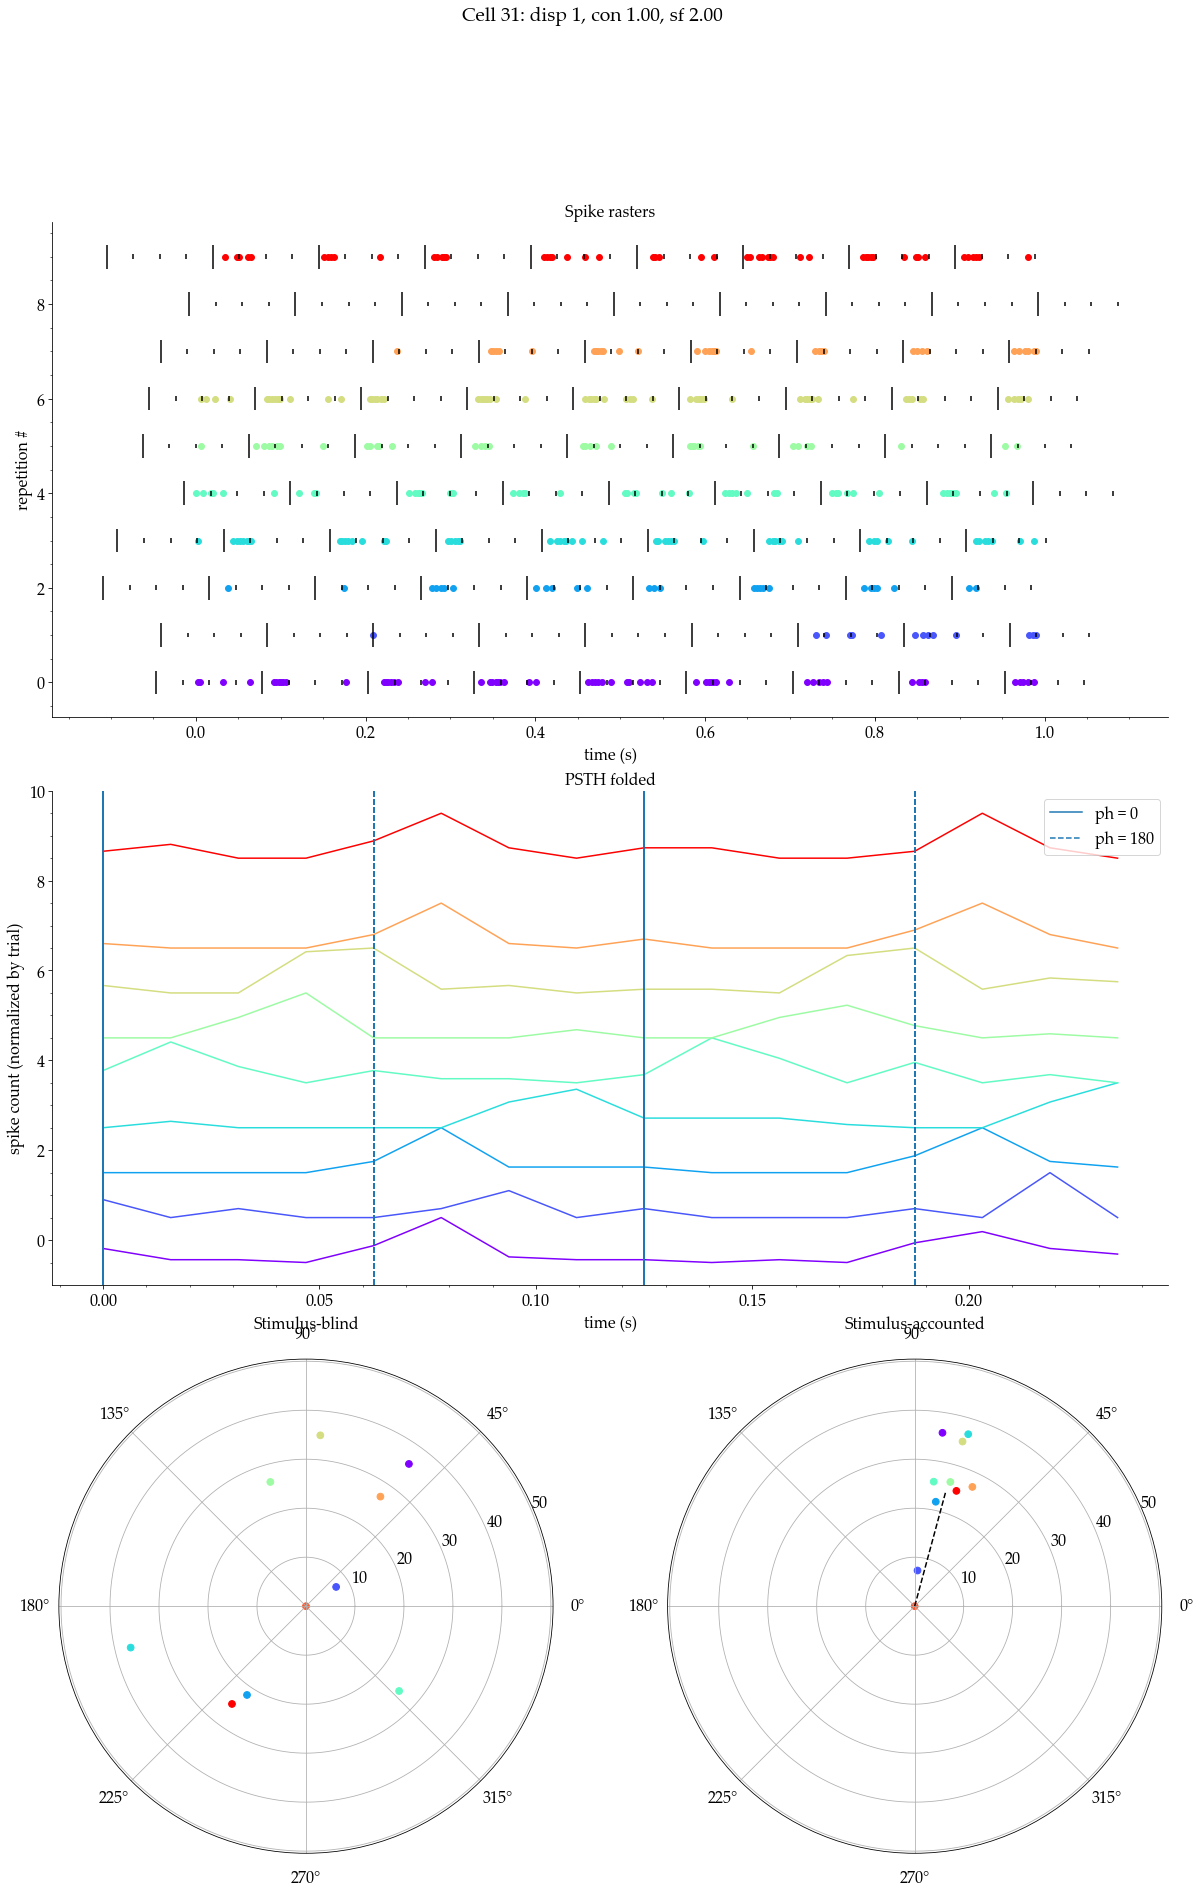

In [10]:
f, ax = plt.subplots(3, 2, figsize=(20, 30))

relSpikes = data['spikeTimes'][val_trials];
colors = cm.rainbow(np.linspace(0, 1, len(val_trials[0])))

# spike raster - trial-by-trial
# only works for SINGLE GRATINGS
# draw the beginning of each cycle for each trial
ax = plt.subplot(3, 1, 1)
for i in range(len(relSpikes)):
    ax.scatter(relSpikes[i], i*np.ones_like(relSpikes[i]), s=35, color=colors[i]);
    stimPh = stim_phase[i];
    stimPeriod = np.divide(1, all_tf[i]);
    # i.e. at what point during the trial (in s) does the stimulus component first begin a cycle?
    firstPh0 = helper_fcns.first_ph0(stimPh, all_tf[i])[1];
    for j in range(len(all_tf[i])):
        allPh0 = [stimPeriod[j]*np.arange(-1, all_tf[i][j]) + firstPh0[j]];
        allPh90 = allPh0 + stimPeriod[j]/4;
        allPh180 = allPh90 + stimPeriod[j]/4;
        allPh270 = allPh180 + stimPeriod[j]/4;
    ax.errorbar(allPh0[0], i*np.ones_like(allPh0[0]), 0.25, linestyle='none', color='k')
    ax.errorbar(allPh90[0], i*np.ones_like(allPh0[0]), 0.05, linestyle='none', color='k')
    ax.errorbar(allPh180[0], i*np.ones_like(allPh0[0]), 0.05, linestyle='none', color='k')
    ax.errorbar(allPh270[0], i*np.ones_like(allPh0[0]), 0.05, linestyle='none', color='k')
ax.set_xlabel('time (s)');
ax.set_ylabel('repetition #');
ax.set_title('Spike rasters');

# PSTH - per trial, but folded over N cycles
# only works for SINGLE GRATINGS
ax = plt.subplot(3, 1, 2)
for i in range(len(relSpikes)):
    _, bin_edges, psth_norm = helper_fcns.fold_psth(relSpikes[i], all_tf[i], resp_phase[i], cycle_fold, n_bins);
    plt.plot(bin_edges[0:-1], i-0.5+psth_norm, color=colors[i])
    for i in range(cycle_fold):
        cycStart = plt.axvline(i*stimPeriod[0]);
        cycHalf = plt.axvline((i+0.5)*stimPeriod[0], linestyle='--');
ax.set_xlabel('time (s)');
ax.set_ylabel('spike count (normalized by trial)');
ax.set_title('PSTH folded');
ax.legend((cycStart, cycHalf), ('ph = 0', 'ph = 180'));

# response phase - without accounting for stimulus phase
ax = plt.subplot(3, 2, 5, projection='polar')
ax.scatter(np.radians(resp_phase), rel_amp, s=45, color=colors, clip_on=False);
ax.set_title('Stimulus-blind')
ax.set_ylim(auto='True')
polar_ylim = ax.get_ylim();

# response phase - relative to stimulus phase
ax = plt.subplot(3, 2, 6, projection='polar')
ax.scatter(np.radians(ph_rel_stim), rel_amp, s=45, color=colors, clip_on=False);
ax.plot([0, np.radians(th[0])], [0, r[0]], ls='--', color='k');
ax.set_ylim(polar_ylim);
ax.set_title('Stimulus-accounted');

f.subplots_adjust(wspace=0.2, hspace=0.15);
f.suptitle('Cell %d: disp %d, con %.2f, sf %.2f' % (which_cell, allDisps[disp], allCons[con], allSfs[sf]));

Now save!

In [15]:
saveName = "/cell_%03d_d%dsf%dcon%d_phase.pdf" % (which_cell, disp, sf, con);
full_save = os.path.dirname(str(save_loc));
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f);
plt.close(f);
pdfSv.close();

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


### How to add these vectors?

Well, if $v1$ and $v2$ are vectors in polar coordinates (i.e. $v_i = x_i + iy_i)$, then we simply sum the components, i.e. $\Sigma{v_i} = \Sigma{x_i} + i\Sigma{y_i}$. Just perform the usual transformation on the $(r, \theta)$ representation used to create the plots above, and go from there! 

Originally sketched out here, it's now completed in the helper_fcn "polar_vec_mean"

In [11]:
autoreload.reload(helper_fcns);

Assuming the data file is already loaded, let's start:

In [12]:
resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = helper_fcns.tabulate_responses(cellStruct);

In [13]:
valDisp = validByStimVal[0];
valCon = validByStimVal[1];
valSf = validByStimVal[2];

allDisps = stimVals[0];
allCons = stimVals[1];
allSfs = stimVals[2];

Let's iterate over all contrasts for a given SF/dispersion combination:

In [14]:
disp = 0; sf = 4; # as indices
con_inds = val_con_by_disp[disp];

In [15]:
amps = [];
phis = [];
for i in con_inds:
    val_trials = np.where(valDisp[disp] & valCon[i] & valSf[sf])
    
    # get the relevant amplitudes (i.e. the amplitudes at the stimulus TF)
    psth_val, _ = helper_fcns.make_psth(binWidth, stimDur, data['spikeTimes'][val_trials])
    _, rel_amp, _ = helper_fcns.spike_fft(psth_val, all_tf)
    amps.append(rel_amp);
    # get the phase of the response relative to the stimulus (ph_rel_stim)
    ph_rel_stim, st, re, _ = helper_fcns.get_true_phase(data, val_trials, dir=1);
    phis.append(ph_rel_stim);

In [16]:
r, th = helper_fcns.polar_vec_mean(amps, phis);

Reproduce fig 6(a/b) of Movshon, Kiorpes, Hawken, and Cavanaugh (2005) - response amplitude as a function of contrast, and polar plots of response/phase per condition

In [17]:
autoreload.reload(helper_fcns);

Get the models/fits we need

In [18]:
# phase advance
phAdv_model, opt_params_phAdv = helper_fcns.phase_advance([r], [th]);
opt_params_phAdv = opt_params_phAdv[0];
# rvc
con_values = allCons[con_inds];
rvc_model, opt_params_rvc = helper_fcns.rvc_fit([r], [con_values]);
opt_params_rvc = opt_params_rvc[0];

/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/functions/helper_fcns.py:212: RuntimeWarning: divide by zero encountered in true_divide
  rvc_model = lambda b, k, c0, cons: b + k*np.log(1+np.divide(cons, c0));
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


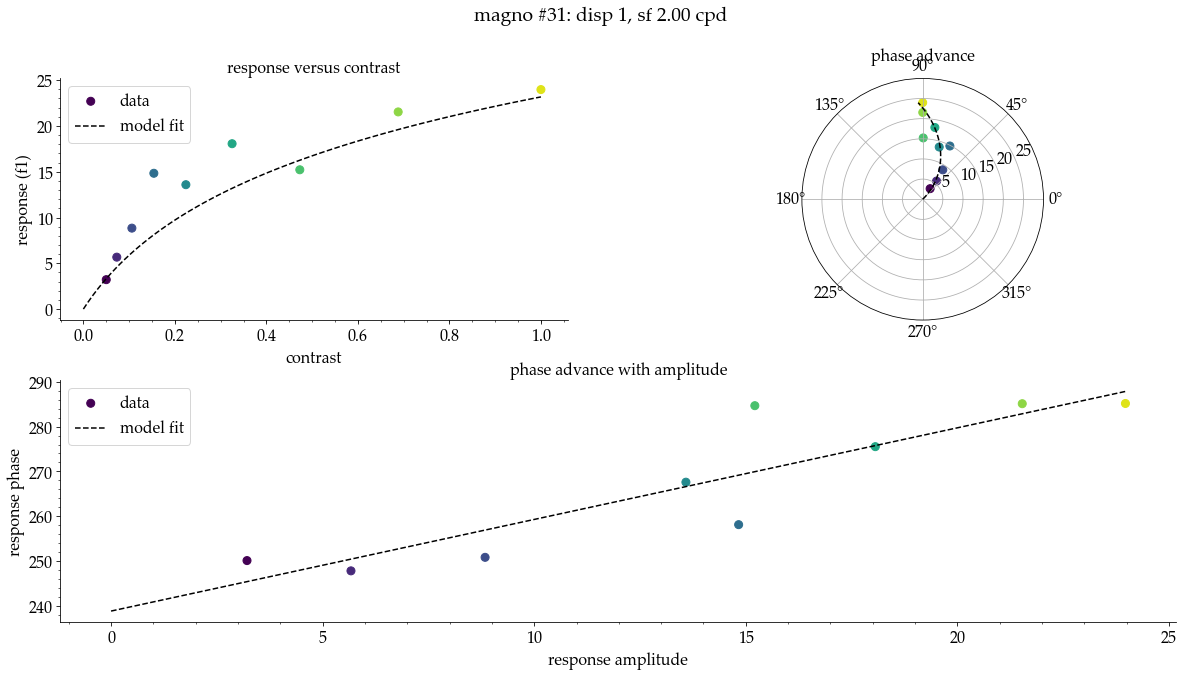

In [20]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

n_conds = len(r);
colors = cm.viridis(np.linspace(0, 0.95, n_conds));

# first, response amplitude (with linear contrast) and rvc model fit
plot_cons = np.linspace(0, 1, 100);
mod_fit = rvc_model(opt_params_rvc[0], opt_params_rvc[1], opt_params_rvc[2], plot_cons);

ax = plt.subplot(2, 2, 1);
plt_measured = ax.scatter(allCons[con_inds], r, color=colors);
plt_fit = ax.plot(plot_cons, mod_fit, linestyle='--', color='k');
ax.set_xlabel('contrast');
ax.set_ylabel('response (f1)');
ax.set_title('response versus contrast')
ax.legend((plt_measured, plt_fit[0]), ('data', 'model fit'))

# then the plot of phase as a function of ampltude with phase advance model
plot_amps = np.linspace(0, np.max(r), 100);
mod_fit = phAdv_model(opt_params_phAdv[0], opt_params_phAdv[1], plot_amps);

ax = plt.subplot(2, 1, 2);
plt_measured = ax.scatter(r, th, color=colors);
plt_fit = ax.plot(plot_amps, mod_fit, linestyle='--', color='k');
ax.set_xlabel('response amplitude');
ax.set_ylabel('response phase');
ax.set_title('phase advance with amplitude')
ax.legend((plt_measured, plt_fit[0]), ('data', 'model fit'))

# now the polar plot of resp/phase together
ax = plt.subplot(2, 2, 2, projection='polar')
# ax.scatter(np.radians(th), r, color=colors)
ax.scatter(np.radians(th-th[-1]+90), r, color=colors)
ax.plot(np.radians(mod_fit-th[-1]+90), plot_amps, linestyle='--', color='k');
ax.set_ylim(0, 1.25*np.max(r))
ax.set_title('phase advance')

# overall title
f.subplots_adjust(wspace=0.2, hspace=0.25);
f.suptitle('%s #%d: disp %d, sf %.2f cpd' % (dataList['unitType'][which_cell-1], which_cell, allDisps[disp], allSfs[sf]));